In [18]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# Read and Calculated EAP for further analysis
# @Yina Wei,March 02,2020
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
import math
import scipy.io

import pickle
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import spline
import os
import h5py
from scipy import signal
import pylab as pl
import csv
#%matplotlib qt
from matplotlib import ticker

from scipy.signal import hilbert, chirp
import allensdk.core.swc as swc
from allensdk.core.cell_types_cache import CellTypesCache
import pprint

import time
starttime = time.time()

def simpleaxis(ax):
    #Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
def clean_axis(ax):
    #Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()       
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def get_loc_electrodes(filepath,filename):
	#"""
	#Read the location of electrode
	#"""
	with open(filepath+filename) as csvDataFile:
	    csvReader = csv.reader(csvDataFile, delimiter=' ')
	    headers=csvReader.next()
	    #for row in csvReader:
	    #    print(row)
	    
	    column = {}
	    for h in headers:
		column[h] = []
		
	    for row in csvReader:
		for h, v in zip(headers, row):
		    column[h].append(float(v))
		    
	z=column['z_pos']   
	x=column['x_pos']
	y=column['y_pos']
        return (x,y,z)


def read_soma_loc(filename):
	hv1 = h5py.File(filename,'r')
	datasetNames=[n for n in hv1.keys()]
	for n in datasetNames:
	    print(n)
	positions=hv1['nodes/v1/0/positions'].value
	x_soma = positions[0][0]
	y_soma = positions[0][1]
	z_soma = positions[0][2]
	node_id = hv1['nodes/v1/node_id'][0]

    	return (x_soma,y_soma,z_soma)

    

def read_rotation_info(filename):
    with open(filename) as csvDataFile:
	csvReader = csv.reader(csvDataFile, delimiter=' ')
	headers=csvReader.next()

	column = {}
	for h in headers:
	    column[h] = []

	for row in csvReader:
	    for h, v in zip(headers, row):
		try:
		    column[h].append(float(v))
		except ValueError:
		     column[h].append(v)
	#cell_id1 = map(int, column['node_type_id'])
	theta_y = column['rotation_angle_yaxis'][0]
	theta_z = column['rotation_angle_zaxis'][0]
	theta_x = column['rotation_angle_xaxis'][0]
        theta = [theta_x,theta_y,theta_z] 
    return theta


def plot_rec_data(samplingrate,lgn_spikes,Vi,spikes,Ve,fig_size=(3.5,5.5)):
    
    T=Vi.shape[0] #The total data points in time serires
    dt = 1000.0/samplingrate # from m to ms
    t=pl.frange(0,T*dt-dt,dt)

    # plot with various axes scales
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot lgn input
    ax=plt.subplot(411)
    plt.eventplot(lgn_spikes,color='k') 
    plt.ylabel('LGN input')
    plt.xlim([0,T*dt])    
    ax.set(xticks=np.arange(0,T*dt+1,(T*dt-0)/2))
    locs, labels = plt.yticks()
    ax.set(yticks=np.arange(0,locs[-1]+1,(locs[-1]-0)/2))
    simpleaxis(ax)
    
    # Plot membrane potential
    ax=plt.subplot(412)
    plt.plot(t,Vi,color='k')
    plt.ylabel('Vi (mV)')
    locs, labels = plt.yticks()
    ax.set(yticks=np.arange(locs[0],locs[-1]+1,(locs[-1]-locs[0])/2))
    simpleaxis(ax)
    plt.xlim([0,T*dt])   
    ax.set(xticks=np.arange(0,T*dt+1,(T*dt-0)/2))
    
    # plot spikes
    ax=plt.subplot(413)
    firingrate = len(spikes)/(round(T*dt))*1000
    ax.eventplot(spikes,color='k')
    plt.ylabel('spikes')
    plt.yticks([])
    plt.title('Firing rate='+str(np.around(firingrate,decimals=2))+'Hz')
    simpleaxis(ax)    
    plt.xlim([0,T*dt])
    ax.set(xticks=np.arange(0,T*dt+1,(T*dt-0)/2))
    
    #plot ecp
    ax=plt.subplot(414)
    somaindx = np.unravel_index(Ve.argmin(),Ve.shape)  #The recording sites that have the largest negative amplitude
    plt.plot(t,Ve[somaindx[0],:],color='k')
    plt.ylabel('Ve (${\mu}$V)')
    simpleaxis(ax)

    plt.xlabel('Time (ms)')
    locs, labels = plt.yticks()
    ax.set(yticks=np.arange(locs[0],locs[-1]+1,(locs[-1]-locs[0])/2))    
    plt.xlim([0,T*dt])
    ax.set(xticks=np.arange(0,T*dt+1,(T*dt-0)/2))
    

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.3)

    return fig

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# function to calculate spike triggered average and covariance for one channels
def cal_STA_STC_onech(data,spikes,win,samplingrate): # data: one_dimensional data
    lwin = win[0]
    hwin = win[1]
    dt = 1000.0/samplingrate # from s to ms
    t_STA = pl.frange(lwin,hwin-dt,dt)
    
    for i in range(0,len(spikes)):
        indx = range(int(spikes[i,]/dt)+int(lwin/dt),int(spikes[i,]/dt)+int(hwin/dt))   #-1ms, +3ms
        if i==0:
            arr=np.array(data[indx])
        else:
            if len(data)>int(spikes[i,]/dt)+int(hwin/dt):
                arr = np.vstack((arr, np.array(data[indx])))
    return t_STA,np.mean(arr,axis=0),np.std(arr,axis=0)

# function to calculate spike triggered average and covariance for multiple channels
def cal_STA_STC(data,spikes,win,samplingrate): # ecp_data: channels*times; output: channels*ecp_win_times
    
    num_channels = data.shape[0]  # number of channels
    
    dt = 1000.0/samplingrate      # from s to ms
    times=int((win[1]-win[0])/dt)
    
    #Calculate STA and STC for multiple channels
    STA = np.array([[0.0]*times]*num_channels)     #spike triggered average
    STC = np.array([[0.0]*times]*num_channels)     #spike triggered standard deviation 

    for i in range(num_channels):
        t_STA,STA[i,:],STC[i,:]=cal_STA_STC_onech(data[i,:],spikes,win,samplingrate)
    
    return (t_STA,STA,STC)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx 

In [2]:
#""""
#Setup file directory
#""""
filedir0 = '../examples/'
cell_id = [571654895]
filedir = filedir0+str(cell_id[0])+'_example/'

In [3]:
#"""
#Read the location of electrode
#"""
ele_filepath = filedir0+'biophys_components/recXelectrodes/'
ele_filename = 'neuropixel_electrode_1um.csv'
[x,y,z]= get_loc_electrodes(ele_filepath,ele_filename)

#Read the location of neurons
#"""
[x_soma,y_soma,z_soma]=read_soma_loc(filedir+'network/v1_nodes.h5')

# Read the rotation information of neurons
theta = read_rotation_info(filedir+'network/v1_node_types.csv')
theta[2]=-theta[2]

nodes


/home/yinaw/miniconda2/envs/py2/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
#"""
#Read the lgn input files
#"""
lgn_filepath = filedir0+'NWB_files/'
lgn_filename = 'lgn_spikes_30s_rate003.nwb'
lgn_hf = h5py.File(lgn_filepath+lgn_filename,'r')
# Get and print list of datasets within the H5 file
datasetNames=[n for n in lgn_hf.keys()]
for n in datasetNames:
    print(n)
spikes_0=lgn_hf['/processing/trial_0/spike_train/0/data'].value  # spikes of target cell id =0
#print spikes_0

# LGN to V1 connections
hf = h5py.File(filedir+'network/lgn_v1_edges.h5','r')
# Get and print list of datasets within the H5 file
datasetNames=[n for n in hf.keys()]
for n in datasetNames:
    print(n)

source_node_id=np.array(hf['edges/lgn_to_v1/source_node_id'].value)
target_node_id=np.array(hf['edges/lgn_to_v1/target_node_id'].value)

target_idx = np.where(target_node_id==0)
src_cells= source_node_id[target_idx]

print src_cells

lgn_spikes=[]
for i in range(0,len(src_cells)):
    lgn_spikes.append(lgn_hf['/processing/trial_0/spike_train/'+str(src_cells[i])+'/data'])

processing
edges
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [7]:
#""""
#Setup file directory
#""""
datadir=filedir+'output/'

#"""
#Read Data from hdf file format
#"""
# Read H5 files
f = h5py.File(datadir+'cell_vars.h5','r')
fspikes = h5py.File(datadir+'spikes.h5','r')
fecp= h5py.File(datadir+'ecp.h5','r')

# Extract values from H5 files
Vi=f['v/data']
spikes=fspikes['spikes/timestamps']
ecp_rec0=fecp['data']
ecp_rec0=1000 * np.array(ecp_rec0)  # Change the unit from mV to uV
Ve = np.transpose(ecp_rec0)   #ecp_data: channels*times

# Print the attributes:
print("Data dimensions of Vi: ", Vi.shape)
print("Data dimensions of spikes: ", spikes.shape)
print("Data dimensions of Ve for all neurons: ", Ve.shape)

[num_channels,T]=Ve.shape
eleColN=len(np.unique(x))          # the column number of electrodes, for Neuropixel electrode, it is 4
eleRowN = num_channels/eleColN     # the row number of electrodes, for Neuropixel electrode, it is 240

# sample rate
fs=30000 #10000
dt=1000.0/fs # msec
t=pl.frange(0,T*dt-dt,dt) #msec
ts=t/1000  #sec
#print(t.shape)

('Data dimensions of Vi: ', (300003, 1))
('Data dimensions of spikes: ', (87,))
('Data dimensions of Ve for all neurons: ', (15360, 300003))


/home/yinaw/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: numpy.arange


/home/yinaw/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:120: MatplotlibDeprecationWarning: numpy.arange


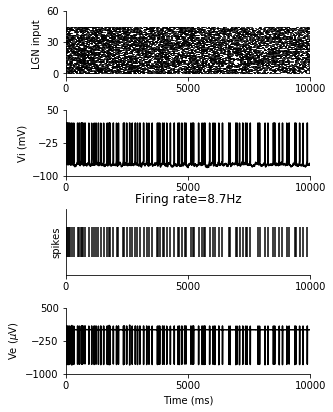

In [9]:
#plot lgn_spikes, vi,spikes,ve at the recording sites closest to the soma
fig = plot_rec_data(fs,lgn_spikes,Vi,spikes,Ve,(4,6))
#fig.savefig(filedir+'output/'+str(cell_id[0])+'data.png',bbox_inches = 'tight')
#fig.savefig(filedir+'output/'+str(cell_id[0])+'data.eps',bbox_inches = 'tight')

In [15]:
print Ve.shape
print Vi.shape

Ve_highpass = np.zeros(Ve.shape)
for i in range(num_channels):
    Ve_highpass[i,:] = butter_highpass_filter(Ve[i,:],300,fs) 

(15360, 300003)
(300003, 1)


In [ ]:
# For each channel, calculate EAP
win=[-1,3] #-1 msec to 3 msec

[t_STA,Ve_STA,Ve_STC] = cal_STA_STC(Ve_highpass,spikes,win,fs) 
[t_STA,Vi_STA,Vi_STC] = cal_STA_STC(np.transpose(Vi),spikes,win,fs)


In [19]:
# The electrode that closest to the soma
ic = find_nearest(np.unique(x),x_soma)   # find the electrode that closest to the soma
ir = find_nearest(np.unique(y),y_soma)   # find the electrode that closest to the soma
print ic,ir

19 115


In [23]:
import numpy as np
import scipy.io
N_spikes = len(spikes)
scipy.io.savemat(filedir+str(cell_id[0])+'EAP.mat', mdict={'t_STA':t_STA, 'EAP_mean':Ve_STA, 'EAP_st':Ve_STC, 'row':ir, 'column':ic,'eleColN':eleColN,'M':num_channels, 'N_spikes':N_spikes})

In [ ]:
# close the h5 file
#f.close()
#lgn_hf.close()
#hf.close()
#hv1.close()
endtime = time.time()
print('The time of data processing is '+str((endtime - starttime)/60)+' mins')